# Задача:

Нам необходимо оптимизировать производственные расходы металлургического комбината ООО «Так закаляем сталь» путём уменьшения потребление электроэнергии на этапе обработки стали. Нам предстоит построить модель, которая предскажет температуру стали(последнюю).

Для этого нам дают описание самого технологического процесса:

Сталь обрабатывают в металлическом ковше вместимостью около 100 тонн. Чтобы ковш выдерживал высокие температуры, изнутри его облицовывают огнеупорным кирпичом. Расплавленную сталь заливают в ковш и подогревают до нужной температуры графитовыми электродами. Они установлены в крышке ковша. 

Из сплава выводится сера (десульфурация), добавлением примесей корректируется химический состав и отбираются пробы. Сталь легируют — изменяют её состав — подавая куски сплава из бункера для сыпучих материалов или проволоку через специальный трайб-аппарат (англ. tribe, «масса»).

Перед тем как первый раз ввести легирующие добавки, измеряют температуру стали и производят её химический анализ. Потом температуру на несколько минут повышают, добавляют легирующие материалы и продувают сплав инертным газом. Затем его перемешивают и снова проводят измерения. Такой цикл повторяется до достижения целевого химического состава и оптимальной температуры плавки.

Тогда расплавленная сталь отправляется на доводку металла или поступает в машину непрерывной разливки. Оттуда готовый продукт выходит в виде заготовок-слябов (англ. *slab*, «плита»).

## Описание данных 
Данные состоят из файлов, полученных из разных источников:

- `data_arc.csv` — данные об электродах;
- `data_bulk.csv` — данные о подаче сыпучих материалов (объём);
- `data_bulk_time.csv` *—* данные о подаче сыпучих материалов (время);
- `data_gas.csv` — данные о продувке сплава газом;
- `data_temp.csv` — результаты измерения температуры;
- `data_wire.csv` — данные о проволочных материалах (объём);
- `data_wire_time.csv` — данные о проволочных материалах (время).

## Доп.информация

https://vulkantm.com/tehnologii/obrabotka-metalla-argonom-v-kovshe/

Развитие современного сталеплавильного производства требует совершенствования методов выплавки и технологии внепечной обработки металла для получения качественных сталей. Внепечная обработка расплава, а именно донная продувка металла инертными газами — важное звено технологического процесса производства стали на участке между сталеплавильным агрегатом и разливкой металла. В настоящее время использование донной продувки металла инертными газами позволяет:

1.повысить производительность сталеплавильного агрегата за счет увеличения скорости химических процессов при внепечной обработки стали;


2.повысить чистоту стали по неметаллическим включениям;


3.осуществить дегазацию металла;

4.создать оптимальные условия для процесса легирования.


Таким образом, продувка металла инертными газами, через донные продувочные пробки и узлы, является эффективной технологией повышения качества разливаемой стали и решения задач ковшевой металлургии (гомогенизация, рафинирование, легирование, дегазация).

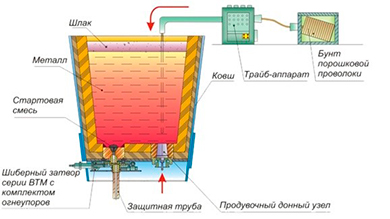

<font color='steelblue'><b>Комментарий тимлида</b></font><br>
<font color='green'>✔️ Описание на месте 👍🏼</font><br>

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import cross_val_score
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import ShuffleSplit
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
import lightgbm as lgb

In [3]:
electrode_data = pd.read_csv('./final_steel/data_arc.csv')
bulk_materials_volume = pd.read_csv('./final_steel/data_bulk.csv')
bulk_materials_time = pd.read_csv('./final_steel/data_bulk_time.csv')
alloy_blow_data = pd.read_csv('./final_steel/data_gas.csv')
temperature_data = pd.read_csv('./final_steel/data_temp.csv')
wire_material_volume = pd.read_csv('./final_steel/data_wire.csv')
wire_material_time = pd.read_csv('./final_steel/data_wire_time.csv')

# --------------------------------------------------------

# 1. Предварительный просмотр данных 

## 1.1 Данные об электродах

In [5]:
electrode_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   key                   14876 non-null  int64  
 1   Начало нагрева дугой  14876 non-null  object 
 2   Конец нагрева дугой   14876 non-null  object 
 3   Активная мощность     14876 non-null  float64
 4   Реактивная мощность   14876 non-null  float64
dtypes: float64(2), int64(1), object(2)
memory usage: 581.2+ KB


In [6]:
electrode_data.head()

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.976059,0.687084
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.805607,0.520285
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.744363,0.498805
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,1.659363,1.062669
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.692755,0.414397


## 1.2 Данные о подаче сыпучих материалов

In [7]:
bulk_materials_time.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   key      3129 non-null   int64 
 1   Bulk 1   252 non-null    object
 2   Bulk 2   22 non-null     object
 3   Bulk 3   1298 non-null   object
 4   Bulk 4   1014 non-null   object
 5   Bulk 5   77 non-null     object
 6   Bulk 6   576 non-null    object
 7   Bulk 7   25 non-null     object
 8   Bulk 8   1 non-null      object
 9   Bulk 9   19 non-null     object
 10  Bulk 10  176 non-null    object
 11  Bulk 11  177 non-null    object
 12  Bulk 12  2450 non-null   object
 13  Bulk 13  18 non-null     object
 14  Bulk 14  2806 non-null   object
 15  Bulk 15  2248 non-null   object
dtypes: int64(1), object(15)
memory usage: 391.2+ KB


In [8]:
bulk_materials_time.head()

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,2019-05-03 11:21:30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:03:52,NaN,2019-05-03 11:03:52,2019-05-03 11:03:52
1,2,NaN,NaN,NaN,2019-05-03 11:46:38,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:40:20,NaN,2019-05-03 11:40:20,2019-05-03 11:40:20
2,3,NaN,NaN,NaN,2019-05-03 12:31:06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:09:40,NaN,2019-05-03 12:09:40,2019-05-03 12:09:40
3,4,NaN,NaN,NaN,2019-05-03 12:48:43,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:41:24,NaN,2019-05-03 12:41:24,2019-05-03 12:41:24
4,5,NaN,NaN,NaN,2019-05-03 13:18:50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 13:12:56,NaN,2019-05-03 13:12:56,2019-05-03 13:12:56


In [9]:
bulk_materials_volume.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3129 non-null   int64  
 1   Bulk 1   252 non-null    float64
 2   Bulk 2   22 non-null     float64
 3   Bulk 3   1298 non-null   float64
 4   Bulk 4   1014 non-null   float64
 5   Bulk 5   77 non-null     float64
 6   Bulk 6   576 non-null    float64
 7   Bulk 7   25 non-null     float64
 8   Bulk 8   1 non-null      float64
 9   Bulk 9   19 non-null     float64
 10  Bulk 10  176 non-null    float64
 11  Bulk 11  177 non-null    float64
 12  Bulk 12  2450 non-null   float64
 13  Bulk 13  18 non-null     float64
 14  Bulk 14  2806 non-null   float64
 15  Bulk 15  2248 non-null   float64
dtypes: float64(15), int64(1)
memory usage: 391.2 KB


In [10]:
bulk_materials_volume.head()

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,150.0,154.0
1,2,NaN,NaN,NaN,73.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,149.0,154.0
2,3,NaN,NaN,NaN,34.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,205.0,NaN,152.0,153.0
3,4,NaN,NaN,NaN,81.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,207.0,NaN,153.0,154.0
4,5,NaN,NaN,NaN,78.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,151.0,152.0


## 1.3 Данные о подаче газа

In [11]:
alloy_blow_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3239 entries, 0 to 3238
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3239 non-null   int64  
 1   Газ 1   3239 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 50.7 KB


In [12]:
alloy_blow_data.head()

,key,Газ 1
0,1,29.749986
1,2,12.555561
2,3,28.554793
3,4,18.841219
4,5,5.413692


## 1.4 Данные о температуре

In [13]:
temperature_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15907 entries, 0 to 15906
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   key           15907 non-null  int64  
 1   Время замера  15907 non-null  object 
 2   Температура   13006 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 372.9+ KB


In [14]:
temperature_data.head()

,key,Время замера,Температура
0,1,2019-05-03 11:16:18,1571.0
1,1,2019-05-03 11:25:53,1604.0
2,1,2019-05-03 11:29:11,1618.0
3,1,2019-05-03 11:30:01,1601.0
4,1,2019-05-03 11:30:39,1613.0


## Данные о подаче проволочных материалов

In [15]:
wire_material_time.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   key     3081 non-null   int64 
 1   Wire 1  3055 non-null   object
 2   Wire 2  1079 non-null   object
 3   Wire 3  63 non-null     object
 4   Wire 4  14 non-null     object
 5   Wire 5  1 non-null      object
 6   Wire 6  73 non-null     object
 7   Wire 7  11 non-null     object
 8   Wire 8  19 non-null     object
 9   Wire 9  29 non-null     object
dtypes: int64(1), object(9)
memory usage: 240.8+ KB


In [16]:
wire_material_time.head()

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,2019-05-03 11:11:41,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,2019-05-03 11:46:10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,2019-05-03 12:13:47,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,2019-05-03 12:48:05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,2019-05-03 13:18:15,2019-05-03 13:32:06,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [17]:
wire_material_volume.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3081 non-null   int64  
 1   Wire 1  3055 non-null   float64
 2   Wire 2  1079 non-null   float64
 3   Wire 3  63 non-null     float64
 4   Wire 4  14 non-null     float64
 5   Wire 5  1 non-null      float64
 6   Wire 6  73 non-null     float64
 7   Wire 7  11 non-null     float64
 8   Wire 8  19 non-null     float64
 9   Wire 9  29 non-null     float64
dtypes: float64(9), int64(1)
memory usage: 240.8 KB


In [18]:
wire_material_volume.head()

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,60.059998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,96.052315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,91.160157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,89.063515,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,89.238236,9.11456,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# 2. Анализ данных 

In [19]:
electrode_data['Конец нагрева дугой'] = pd.to_datetime(electrode_data['Конец нагрева дугой'].astype(str), \
                                                       format='%Y-%m-%d %H:%M:%S')

In [20]:
temperature_data['Время замера'] = pd.to_datetime(temperature_data['Время замера'].astype(str), \
                                                  format='%Y-%m-%d %H:%M:%S')

count    3216.000000
mean     1588.592040
std        29.137454
min      1191.000000
25%      1572.000000
50%      1588.000000
75%      1606.000000
max      1684.000000
Name: Температура, dtype: float64


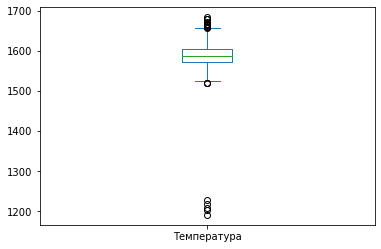

In [21]:
temperature_data.loc[temperature_data.groupby('key')['Время замера'].idxmin()]['Температура'].plot.box()
print(temperature_data.loc[temperature_data.groupby('key')['Время замера'].idxmin()]['Температура'].describe())

count    2477.000000
mean     1595.334275
std        16.019339
min      1541.000000
25%      1587.000000
50%      1593.000000
75%      1599.000000
max      1700.000000
Name: Температура, dtype: float64


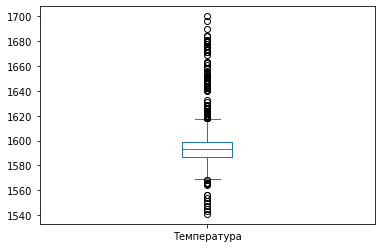

In [22]:
temperature_data.loc[temperature_data.groupby('key')['Время замера'].idxmax()]['Температура'].plot.box()
print(temperature_data.loc[temperature_data.groupby('key')['Время замера'].idxmax()]['Температура'].describe())

**Видно, что количество значений для последних и для начальных замеров отличается (2477 vs 3216), посмотрим подробнее**

In [23]:
a = set(temperature_data.iloc[list(temperature_data.loc[temperature_data.groupby('key')['Время замера'].\
                                                        idxmin()]['Температура'].index)].key)

In [24]:
len(a)

3216

In [25]:
temperature_data.loc[temperature_data.groupby('key')['Время замера'].\
                                                        idxmax()]['Температура']

4        1613.0
10       1602.0
15       1599.0
18       1625.0
20       1602.0
          ...  
15882       NaN
15885       NaN
15893       NaN
15901       NaN
15906       NaN
Name: Температура, Length: 3216, dtype: float64

In [26]:
b = set(temperature_data.iloc[list(temperature_data.loc[temperature_data.groupby('key')['Время замера'].\
                                                        idxmax()]['Температура'].dropna().index)].key)

In [27]:
len(b)

2477

**Получил список значений колонки key, в которых присутсвует NaN-ы, посмотрим не ошибки ли это в приборах самого измерения температуры** 

In [28]:
set(a) - set(b)

{2500,
 2501,
 2502,
 2503,
 2504,
 2505,
 2506,
 2507,
 2508,
 2509,
 2510,
 2511,
 2512,
 2513,
 2514,
 2515,
 2516,
 2517,
 2518,
 2519,
 2520,
 2521,
 2522,
 2523,
 2524,
 2525,
 2526,
 2527,
 2528,
 2529,
 2530,
 2531,
 2532,
 2533,
 2534,
 2535,
 2536,
 2537,
 2538,
 2539,
 2540,
 2541,
 2542,
 2543,
 2544,
 2545,
 2546,
 2547,
 2548,
 2549,
 2550,
 2551,
 2552,
 2553,
 2554,
 2555,
 2556,
 2557,
 2558,
 2559,
 2560,
 2561,
 2562,
 2563,
 2564,
 2565,
 2566,
 2567,
 2568,
 2569,
 2570,
 2571,
 2572,
 2573,
 2574,
 2575,
 2576,
 2577,
 2578,
 2579,
 2580,
 2581,
 2582,
 2583,
 2584,
 2585,
 2586,
 2587,
 2588,
 2589,
 2590,
 2591,
 2592,
 2593,
 2594,
 2595,
 2596,
 2597,
 2598,
 2599,
 2600,
 2601,
 2602,
 2603,
 2604,
 2605,
 2606,
 2607,
 2608,
 2609,
 2610,
 2611,
 2612,
 2613,
 2614,
 2615,
 2616,
 2617,
 2618,
 2619,
 2620,
 2621,
 2622,
 2623,
 2624,
 2625,
 2626,
 2627,
 2628,
 2629,
 2630,
 2631,
 2632,
 2633,
 2634,
 2635,
 2636,
 2637,
 2638,
 2639,
 2640,
 2641,
 2642,

**Возьмём к примеру значение key=2516, и рассмотрим его подробнее**

In [29]:
bulk_materials_volume[bulk_materials_volume['key'] == 2516]

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
2424,2516,NaN,NaN,NaN,NaN,NaN,196.0,NaN,NaN,NaN,NaN,18.0,108.0,NaN,504.0,110.0


In [30]:
bulk_materials_time[bulk_materials_time['key'] == 2516]

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
2424,2516,NaN,NaN,NaN,NaN,NaN,2019-08-06 15:44:40,NaN,NaN,NaN,NaN,2019-08-06 15:44:40,2019-08-06 15:37:03,NaN,2019-08-06 15:37:03,2019-08-06 15:37:03


In [31]:
wire_material_time[wire_material_time['key'] == 2516]

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
2389,2516,2019-08-06 15:41:06,2019-08-06 15:46:26,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [32]:
wire_material_volume[wire_material_volume['key'] == 2516]

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
2389,2516,48.87792,100.040726,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [33]:
temperature_data[temperature_data['key'] == 2516]

,key,Время замера,Температура
12353,2516,2019-08-06 15:34:26,1558.0
12354,2516,2019-08-06 15:53:00,NaN
12355,2516,2019-08-06 16:03:16,NaN
12356,2516,2019-08-06 16:07:28,NaN


In [34]:
electrode_data[electrode_data['key'] == 2516]

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
11539,2516,2019-08-06 15:30:06,2019-08-06 15:32:14,0.427410,0.313679
11540,2516,2019-08-06 15:34:38,2019-08-06 15:38:58,0.944326,0.707012
11541,2516,2019-08-06 15:46:30,2019-08-06 15:51:32,1.082475,0.907869
11542,2516,2019-08-06 15:53:14,2019-08-06 15:58:32,1.135908,0.883644
11543,2516,2019-08-06 15:59:59,2019-08-06 16:02:02,0.473098,0.401731
11544,2516,2019-08-06 16:03:31,2019-08-06 16:06:45,0.765933,0.621405


**Видно что количество замеров температуры(4 учитывая NaN) во не совпадает с суммарным кол-вом добавлений сыпучих и проволочных материалов (4+2), ну и просто видно что отсутсвуют значения замеров температуры (NaN), что наводит на мысль что скорее всего либо данные битые иначе как обьяснить почему даже кол-во замеров(4 с NaN), не совпадает со значениями добавлений материалов, ну либо же просто сломался прибор для измерения температуры(хотя первую температуру он всегда замеряет??). Вообщем скорее всего данные битые**  

**Посмотрим на 'нормальные' данные в которых кол-во замеров температуры совпадает с кол-вом значений температуры**

In [35]:
a = temperature_data.groupby(by='key').count()

In [36]:
a[a['Время замера'] == a['Температура']]

,Время замера,Температура
key,,
1,5,5
2,6,6
3,5,5
4,3,3
5,2,2
...,...,...
2495,3,3
2496,4,4
2497,2,2


**И кол-во нормальных значений (2477) совпало с кол-вом нормальных последних замеров температуры, что видимо еще нас наталкивает на мысль что нужно работать лишь с этими данными, а все остальные где присутствует время замера температуры, но отсутсвует само значение температуры, отбросить!**

In [37]:
temperature_data = temperature_data[temperature_data['key'].isin([x for x in range(1,2500)])] 

count    2477.000000
mean     1595.334275
std        16.019339
min      1541.000000
25%      1587.000000
50%      1593.000000
75%      1599.000000
max      1700.000000
Name: Температура, dtype: float64


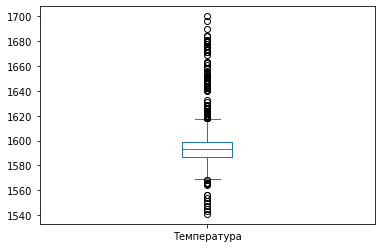

In [38]:
temperature_data.loc[temperature_data.groupby('key')['Время замера'].idxmax()]['Температура'].plot.box()
print(temperature_data.loc[temperature_data.groupby('key')['Время замера'].idxmax()]['Температура'].describe())

count    2477.000000
mean     1588.405733
std        29.232904
min      1191.000000
25%      1572.000000
50%      1588.000000
75%      1605.000000
max      1679.000000
Name: Температура, dtype: float64


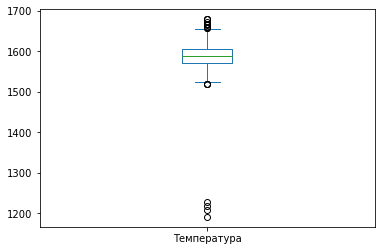

In [39]:
temperature_data.loc[temperature_data.groupby('key')['Время замера'].idxmin()]['Температура'].plot.box()
print(temperature_data.loc[temperature_data.groupby('key')['Время замера'].idxmin()]['Температура'].describe())

**Заджоиним две таблицы и посмотрим есть ли разница между ключами данных таблиц и что в этих ключах интересного**

In [40]:
a = electrode_data.merge(bulk_materials_time, on='key', how='right').key.unique()

In [41]:
b = electrode_data.merge(bulk_materials_time, on='key', how='outer').key.unique()

In [42]:
no_bulk_add = (set(b) - set(a))

In [43]:
len(list(set(b) - set(a)))

86

**Давайте получше рассмотрим данную аномалию**

In [44]:
electrode_data[electrode_data['key'] == 51]

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
238,51,2019-05-05 05:45:24,2019-05-05 05:47:41,0.495662,0.343805
239,51,2019-05-05 05:49:45,2019-05-05 05:59:56,2.772319,1.872731
240,51,2019-05-05 06:01:34,2019-05-05 06:09:39,2.152518,1.434526
241,51,2019-05-05 06:10:30,2019-05-05 06:11:30,0.264215,0.176665


In [45]:
temperature_data[temperature_data['key'] == 51]

,key,Время замера,Температура
293,51,2019-05-05 05:48:48,1619.0
294,51,2019-05-05 06:01:18,1660.0
295,51,2019-05-05 06:10:21,1690.0


In [46]:
bulk_materials_time[bulk_materials_time['key'] == 51]

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15


In [47]:
wire_material_time[wire_material_time['key'] == 51]

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9


**Получается довольно странно что температуры плавления увеличиваются но при этом ни сыпучие не проволочные материалы добавляются судя по таблице, странно..... Попробуем найти те значения в которых не происходит добавления ни проволоки ни супучих материалов**

In [48]:
a = electrode_data.merge(wire_material_time, on='key', how='right').key.unique()

In [49]:
b = electrode_data.merge(wire_material_time, on='key', how='outer').key.unique()

In [50]:
no_wire_add = set(b) - set(a)

In [51]:
no_wire_add.intersection(no_bulk_add)

{51,
 52,
 53,
 54,
 55,
 56,
 81,
 269,
 330,
 331,
 332,
 931,
 933,
 934,
 1105,
 1566,
 1818,
 1979,
 2010,
 2043,
 2195,
 2196,
 2197,
 2198,
 2216,
 2217,
 2390,
 2625,
 2628,
 2863}

**Убираем эти значения из таблицы temperature_data(Почему отсюда скорее всего спросите вы, но пару строк назад я удалил значения key из этой же таблицы, в которых кол-во замеров и кол-во измерений температуры не совпаали, поэтому получается что в этой таблице будут храниться 'хороший' значения key, которые удовлетворяют нас)**

In [52]:
temperature_data = temperature_data[~temperature_data['key'].isin(no_wire_add.intersection(no_bulk_add))]

# План работы 

Все результаты своей деятельности на данный момент описаны в пункте "План работы v3", поэтому постораюсь подробнее описать план своей работы:

* Вкратце опишу датасет, какие были преоставлены таблицы и для чего они

* Опишу какие методы анализа и к какие таблицы я использовал для этого анализа а также какие были найдены аномамалии в данных в результате данного анализа и как с ними я поступал, чтобы привести датасет в логически верный вариант.

* Затем опишу про features_engineering, а именно какие новые фичи я создал(Суммарный обьем добавленного сыпучего материала по ключу' 'Суммарный обьем добавленного проволочного материала по ключу','соотношение активной к реактивной мощности') и опишу зачем я это сделал

* Создал итоговую таблицу обьединенную по ключам для обучения, где кажому ключу будет соответвовать новые фичи представленные в пред.пункте а также первая температура и последняя используемая в качестве таргета.

* Опишу какие модели машинного обучения я использую, опишу какие использовал гиперпараметры модели(В результате Grid_search) и какую именно я выбрал итоговую модель после кросс-валидации, опишу что в качестве целевой метрики качества модели буду использовать MAE, по которому и будет отбираться самая лучшая модель

* Опишу какие результаты(метрика MAE) моделей были получены на тестовых выборках 

**Новый план работы в конце**

## 2.1 Длительность времени между первым и последним замером температуры

In [53]:
min_time_temp_measure = temperature_data.loc[temperature_data.groupby('key')['Время замера'].idxmin()]['Время замера'].reset_index(drop=True)

In [54]:
max_time_temp_measure = temperature_data.loc[temperature_data.groupby('key')['Время замера'].idxmax()]['Время замера'].reset_index(drop=True)

<font color='steelblue'><b>Комментарий тимлида</b></font><br>
<font color='darkorange'>⚠️ min и max — функции Python, не нужно их переопределять, придумай другие имена переменным.</font>

✔️ Выполнено

In [55]:
min_time_temp_measure.index = list(temperature_data.key.unique())
max_time_temp_measure.index = list(temperature_data.key.unique())

count     2450.000000
mean      1862.324898
std       1304.546433
min          0.000000
25%       1189.250000
50%       1599.000000
75%       2265.000000
max      23537.000000
Name: Время замера, dtype: float64

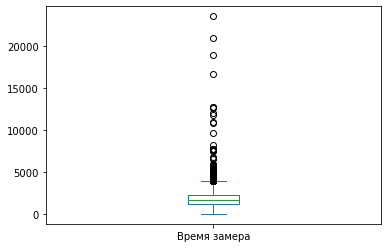

In [56]:
(max_time_temp_measure - min_time_temp_measure).astype('timedelta64[s]').plot.box()
(max_time_temp_measure - min_time_temp_measure).astype('timedelta64[s]').describe()

In [57]:
max_time_temp_measure

1      2019-05-03 11:30:39
2      2019-05-03 11:59:12
3      2019-05-03 12:34:57
4      2019-05-03 12:59:25
5      2019-05-03 13:36:01
               ...        
2495   2019-08-06 00:54:42
2496   2019-08-06 01:29:52
2497   2019-08-06 01:53:50
2498   2019-08-06 02:25:31
2499   2019-08-06 03:00:28
Name: Время замера, Length: 2450, dtype: datetime64[ns]

In [58]:
diff_time = ((max_time_temp_measure - min_time_temp_measure).astype('timedelta64[s]'))

In [59]:
diff_time[diff_time > 4500]

44      10773.0
45       4777.0
46      12010.0
115      5878.0
118      9598.0
274      6518.0
322      6725.0
390      4653.0
460      4859.0
461      5612.0
507      5311.0
638     12789.0
639      7506.0
641     16669.0
650      5705.0
686      4675.0
687      5388.0
801     12753.0
904      4630.0
959      7687.0
987      4918.0
1269     7743.0
1290     4787.0
1470     4591.0
1513    10954.0
1689    23537.0
1760     5069.0
1855     5347.0
1866     5198.0
1880    11819.0
1881    12643.0
1903     4707.0
1923     5209.0
1943     5682.0
1958    18948.0
2001     7510.0
2047     4535.0
2097     5261.0
2106     7708.0
2107     8194.0
2108    20923.0
2109     6658.0
2110     5919.0
2150     5629.0
2151     7646.0
2229     5069.0
2359     5490.0
2366     5841.0
2439     4504.0
Name: Время замера, dtype: float64

In [60]:
electrode_data[electrode_data['key'] == 44]

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
190,44,2019-05-04 22:09:23,2019-05-04 22:11:49,0.514491,0.406311
191,44,2019-05-04 22:14:17,2019-05-04 22:17:39,0.691813,0.554531
192,44,2019-05-04 22:19:54,2019-05-04 22:24:09,0.927365,0.654955
193,44,2019-05-04 22:30:57,2019-05-04 22:31:39,0.155866,0.112500
194,44,2019-05-04 22:32:45,2019-05-04 22:34:57,0.501012,0.339709
195,44,2019-05-04 22:44:58,2019-05-04 22:46:04,0.253021,0.163590
196,44,2019-05-04 22:47:31,2019-05-04 22:49:34,0.489501,0.352497
197,44,2019-05-05 00:32:02,2019-05-05 00:34:36,0.537892,0.426978
198,44,2019-05-05 00:36:13,2019-05-05 00:46:45,2.343373,1.921817
199,44,2019-05-05 00:49:21,2019-05-05 00:52:55,0.832662,0.637833


In [61]:
wire_material_time[wire_material_time['key'] == 44]

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
41,44,2019-05-04 22:32:10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [62]:
bulk_materials_time[bulk_materials_time['key'] == 44]

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
41,44,NaN,NaN,NaN,NaN,NaN,2019-05-04 22:33:48,NaN,NaN,NaN,NaN,NaN,2019-05-05 00:39:35,2019-05-05 00:39:35,2019-05-04 22:15:42,2019-05-05 00:39:35


In [63]:
temperature_data[temperature_data['key'] == 44]

,key,Время замера,Температура
225,44,2019-05-04 22:13:44,1600.0
226,44,2019-05-04 22:32:26,1608.0
227,44,2019-05-04 22:39:37,1619.0
228,44,2019-05-04 22:43:49,1600.0
229,44,2019-05-04 22:44:29,1605.0
230,44,2019-05-04 22:46:49,1601.0
231,44,2019-05-04 22:47:20,1601.0
232,44,2019-05-04 22:50:26,1607.0
233,44,2019-05-05 00:35:31,1570.0
234,44,2019-05-05 00:48:32,1599.0


## 2.2 Суммарное время нагрева электродами, то есть сумму значений по всем промежуткам между запусками нагрева электродов.

In [64]:
electrode_data = electrode_data.loc[electrode_data['key'].isin(temperature_data.key)]

In [65]:
electrode_data['Начало нагрева дугой'] = pd.to_datetime(electrode_data['Начало нагрева дугой'].astype(str), \
                                                       format='%Y-%m-%d %H:%M:%S')

In [66]:
electrode_data['diff'] = (electrode_data['Конец нагрева дугой'] - electrode_data['Начало нагрева дугой']).astype('timedelta64[s]')

In [67]:
electrode_data.groupby('key').sum()['diff']

key
1       1098.0
2        811.0
3        655.0
4        741.0
5        869.0
         ...  
2495     723.0
2496     940.0
2497     569.0
2498     750.0
2499     883.0
Name: diff, Length: 2448, dtype: float64

count    2448.000000
mean      801.013480
std       340.083389
min        57.000000
25%       574.750000
50%       772.500000
75%       985.250000
max      4189.000000
Name: diff, dtype: float64

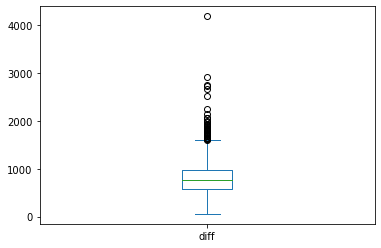

In [68]:
electrode_data.groupby('key').sum()['diff'].plot.box()
electrode_data.groupby('key').sum()['diff'].describe()

## 2.3 Количество запусков нагрева электродами

In [69]:
electrode_data.groupby('key').count()['Активная мощность']

key
1       5
2       4
3       5
4       4
5       4
       ..
2495    4
2496    6
2497    3
2498    5
2499    4
Name: Активная мощность, Length: 2448, dtype: int64

count    2448.000000
mean        4.638889
std         1.608465
min         1.000000
25%         4.000000
50%         4.000000
75%         6.000000
max        16.000000
Name: Активная мощность, dtype: float64

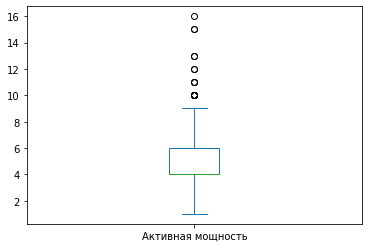

In [70]:
electrode_data.groupby('key').count()['Активная мощность'].plot.box()
electrode_data.groupby('key').count()['Активная мощность'].describe()

## 2.4 Среднее соотношение потребления активной и реактивной мощности.

In [71]:
electrode_data['proportion'] = electrode_data['Активная мощность']/electrode_data['Реактивная мощность']

count    11356.000000
mean         1.363470
std          0.171711
min         -0.000693
25%          1.262177
50%          1.377256
75%          1.482687
max          1.949831
Name: proportion, dtype: float64

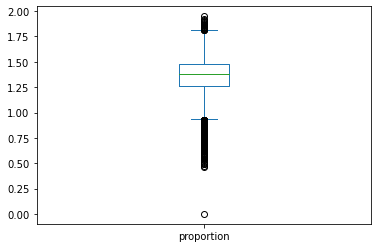

In [72]:
electrode_data['proportion'].plot.box()
electrode_data['proportion'].describe()

In [73]:
electrode_data.corr()

,key,Активная мощность,Реактивная мощность,diff,proportion
key,1.000000,-0.002689,-0.010304,-0.000486,-0.107003
Активная мощность,-0.002689,1.000000,0.048462,0.973280,0.020174
Реактивная мощность,-0.010304,0.048462,1.000000,0.050690,0.064731
diff,-0.000486,0.973280,0.050690,1.000000,-0.087003
proportion,-0.107003,0.020174,0.064731,-0.087003,1.000000


array([[<AxesSubplot:xlabel='key', ylabel='key'>,
        <AxesSubplot:xlabel='Активная мощность', ylabel='key'>,
        <AxesSubplot:xlabel='Реактивная мощность', ylabel='key'>,
        <AxesSubplot:xlabel='diff', ylabel='key'>,
        <AxesSubplot:xlabel='proportion', ylabel='key'>],
       [<AxesSubplot:xlabel='key', ylabel='Активная мощность'>,
        <AxesSubplot:xlabel='Активная мощность', ylabel='Активная мощность'>,
        <AxesSubplot:xlabel='Реактивная мощность', ylabel='Активная мощность'>,
        <AxesSubplot:xlabel='diff', ylabel='Активная мощность'>,
        <AxesSubplot:xlabel='proportion', ylabel='Активная мощность'>],
       [<AxesSubplot:xlabel='key', ylabel='Реактивная мощность'>,
        <AxesSubplot:xlabel='Активная мощность', ylabel='Реактивная мощность'>,
        <AxesSubplot:xlabel='Реактивная мощность', ylabel='Реактивная мощность'>,
        <AxesSubplot:xlabel='diff', ylabel='Реактивная мощность'>,
        <AxesSubplot:xlabel='proportion', ylabel='Реактив

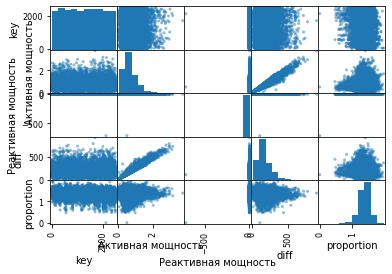

In [74]:
pd.plotting.scatter_matrix(electrode_data)

array([[<AxesSubplot:xlabel='key', ylabel='key'>,
        <AxesSubplot:xlabel='Температура', ylabel='key'>],
       [<AxesSubplot:xlabel='key', ylabel='Температура'>,
        <AxesSubplot:xlabel='Температура', ylabel='Температура'>]],
      dtype=object)

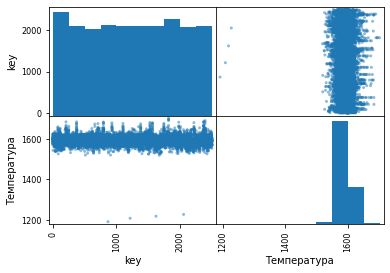

In [75]:
pd.plotting.scatter_matrix(temperature_data)

count    2450.000000
mean     1594.794694
std        14.893932
min      1541.000000
25%      1587.000000
50%      1593.000000
75%      1599.000000
max      1696.000000
Name: Температура, dtype: float64


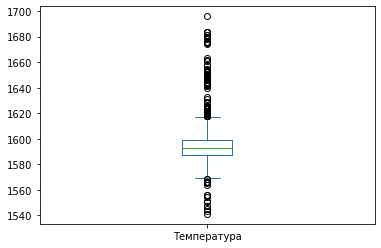

In [76]:
temperature_data.loc[temperature_data.groupby('key')['Время замера'].idxmax()]['Температура'].plot.box()
print(temperature_data.loc[temperature_data.groupby('key')['Время замера'].idxmax()]['Температура'].describe())

count    2450.000000
mean     1587.966939
std        28.977585
min      1191.000000
25%      1571.000000
50%      1587.000000
75%      1605.000000
max      1679.000000
Name: Температура, dtype: float64


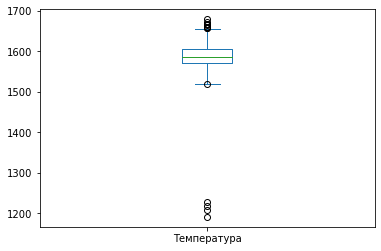

In [77]:
temperature_data.loc[temperature_data.groupby('key')['Время замера'].idxmin()]['Температура'].plot.box()
print(temperature_data.loc[temperature_data.groupby('key')['Время замера'].idxmin()]['Температура'].describe())

## 2.5 Посмотрим как в среднем меняется температура в зависимости от добавления того или иного вещества 

In [78]:
only_wire_add_key = [x for x in no_bulk_add if x not in no_bulk_add.intersection(no_wire_add)]

In [79]:
only_bulk_add_key = [x for x in no_wire_add if x not in no_bulk_add.intersection(no_wire_add)]

In [80]:
only_bulk_add_temp = temperature_data[temperature_data['key'].isin(only_bulk_add_key)]

In [81]:
only_wire_add_temp = temperature_data[temperature_data['key'].isin(only_wire_add_key)]

In [82]:
only_bulk_add_temp

,key,Время замера,Температура
473,82,2019-05-06 06:59:25,1621.0
474,82,2019-05-06 07:06:26,1637.0
475,82,2019-05-06 07:13:04,1659.0
476,82,2019-05-06 07:13:42,1654.0
477,83,2019-05-06 07:36:26,1622.0
...,...,...,...
11749,2392,2019-08-02 09:28:32,1641.0
11750,2392,2019-08-02 09:36:30,1650.0
11751,2393,2019-08-02 09:52:48,1637.0
11752,2393,2019-08-02 10:03:31,1634.0


In [83]:
only_wire_add_temp

,key,Время замера,Температура
417,72,2019-05-05 22:44:33,1590.0
418,72,2019-05-05 22:52:18,1595.0
466,80,2019-05-06 05:27:44,1559.0
467,80,2019-05-06 05:34:13,1574.0
468,80,2019-05-06 05:44:08,1583.0
...,...,...,...
12125,2471,2019-08-05 02:44:19,1597.0
12126,2471,2019-08-05 03:02:09,1583.0
12127,2471,2019-08-05 03:09:32,1583.0
12128,2471,2019-08-05 03:10:09,1584.0


In [84]:
diff_only_bulk = (only_bulk_add_temp.loc[only_bulk_add_temp.groupby('key')['Время замера'].idxmax()]['Температура'].reset_index(drop=True) - only_bulk_add_temp.loc[only_bulk_add_temp.groupby('key')['Время замера'].idxmin()]['Температура'].reset_index(drop=True))

In [85]:
diff_only_wire = (only_wire_add_temp.loc[only_wire_add_temp.groupby('key')['Время замера'].idxmax()]['Температура'].reset_index(drop=True) - only_wire_add_temp.loc[only_wire_add_temp.groupby('key')['Время замера'].idxmin()]['Температура'].reset_index(drop=True))

count     76.000000
mean      19.394737
std       22.038802
min      -25.000000
25%        4.000000
50%       15.000000
75%       28.000000
max      105.000000
Name: Температура, dtype: float64

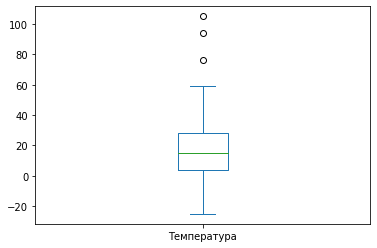

In [86]:
diff_only_bulk.plot.box()
diff_only_bulk.describe()

count    41.000000
mean     -5.878049
std      21.573358
min     -66.000000
25%     -16.000000
50%      -1.000000
75%       9.000000
max      26.000000
Name: Температура, dtype: float64

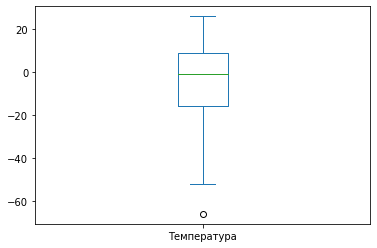

In [87]:
diff_only_wire.plot.box()
diff_only_wire.describe()

In [88]:
electrode_data

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность,diff,proportion
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.976059,0.687084,228.0,1.420582
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.805607,0.520285,185.0,1.548395
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.744363,0.498805,172.0,1.492292
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,1.659363,1.062669,365.0,1.561504
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.692755,0.414397,148.0,1.671717
...,...,...,...,...,...,...,...
11444,2498,2019-08-06 02:19:43,2019-08-06 02:20:24,0.180213,0.116065,41.0,1.552697
11445,2499,2019-08-06 02:32:56,2019-08-06 02:38:08,1.425867,1.043338,312.0,1.366640
11446,2499,2019-08-06 02:41:09,2019-08-06 02:44:34,0.978407,0.627803,205.0,1.558461
11447,2499,2019-08-06 02:46:03,2019-08-06 02:50:58,1.381264,0.894252,295.0,1.544602


**Переименуем колонку diff в diff_seconds для наглядности**

In [89]:
electrode_data.rename(columns={'diff':'diff_seconds'}, inplace=True)

In [90]:
electrode_data

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность,diff_seconds,proportion
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.976059,0.687084,228.0,1.420582
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.805607,0.520285,185.0,1.548395
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.744363,0.498805,172.0,1.492292
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,1.659363,1.062669,365.0,1.561504
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.692755,0.414397,148.0,1.671717
...,...,...,...,...,...,...,...
11444,2498,2019-08-06 02:19:43,2019-08-06 02:20:24,0.180213,0.116065,41.0,1.552697
11445,2499,2019-08-06 02:32:56,2019-08-06 02:38:08,1.425867,1.043338,312.0,1.366640
11446,2499,2019-08-06 02:41:09,2019-08-06 02:44:34,0.978407,0.627803,205.0,1.558461
11447,2499,2019-08-06 02:46:03,2019-08-06 02:50:58,1.381264,0.894252,295.0,1.544602


**Создадим фичу electricity как метрику отражающую время и энергию потраченную на нагрев смеси** 

In [91]:
electrode_data['electricity'] = (electrode_data['Активная мощность']**2)+(electrode_data['Реактивная мощность']**2)

In [92]:
electrode_data['electricity'] = electrode_data['electricity']**0.5

In [93]:
electrode_data['electricity'] = electrode_data['electricity'] * electrode_data['diff_seconds']

In [94]:
electrode_data

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность,diff_seconds,proportion,electricity
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.976059,0.687084,228.0,1.420582,272.149755
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.805607,0.520285,185.0,1.548395,177.416785
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.744363,0.498805,172.0,1.492292,154.118502
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,1.659363,1.062669,365.0,1.561504,719.221394
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.692755,0.414397,148.0,1.671717,119.471318
...,...,...,...,...,...,...,...,...
11444,2498,2019-08-06 02:19:43,2019-08-06 02:20:24,0.180213,0.116065,41.0,1.552697,8.788541
11445,2499,2019-08-06 02:32:56,2019-08-06 02:38:08,1.425867,1.043338,312.0,1.366640,551.247647
11446,2499,2019-08-06 02:41:09,2019-08-06 02:44:34,0.978407,0.627803,205.0,1.558461,238.313354
11447,2499,2019-08-06 02:46:03,2019-08-06 02:50:58,1.381264,0.894252,295.0,1.544602,485.414190


In [95]:
electrode_data.groupby('key').mean()

,Активная мощность,Реактивная мощность,diff_seconds,proportion,electricity
key,,,,,
1,0.975629,0.636648,219.600000,1.538898,288.475551
2,0.763150,0.499528,202.750000,1.551834,220.308391
3,0.505176,0.319815,131.000000,1.583120,105.013355
4,0.802313,0.515074,185.250000,1.563487,199.227827
5,0.836793,0.563161,217.250000,1.480428,299.784489
...,...,...,...,...,...
2495,0.802673,0.590194,180.750000,1.372734,194.704558
2496,0.700511,0.468364,156.666667,1.491059,145.876903
2497,0.737460,0.617090,189.666667,1.192036,185.643450


In [96]:
temperature_data.groupby('key').mean()

,Температура
key,
1,1601.400000
2,1593.500000
3,1597.800000
4,1616.333333
5,1589.000000
...,...
2495,1583.666667
2496,1579.000000
2497,1580.000000


count    11356.000000
mean         0.439992
std          6.726139
min       -715.504924
25%          0.291163
50%          0.417318
75%          0.644522
max          2.676388
Name: Реактивная мощность, dtype: float64

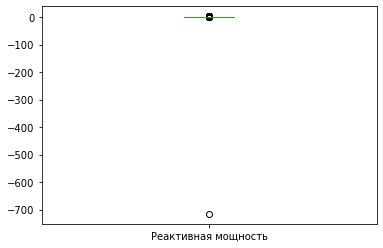

In [97]:
electrode_data['Реактивная мощность'].plot.box()
electrode_data['Реактивная мощность'].describe()

**Нашли аномальное значение в реактивной мощности, уберем его**

In [98]:
electrode_data[electrode_data['Реактивная мощность'] < 0]

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность,diff_seconds,proportion,electricity
9780,2116,2019-07-24 00:44:48,2019-07-24 00:46:37,0.495782,-715.504924,109.0,-0.000693,77990.055458


In [99]:
list(electrode_data[electrode_data['key'] == 2116].index)

[9778, 9779, 9780, 9781]

In [100]:
electrode_data.describe()

,key,Активная мощность,Реактивная мощность,diff_seconds,proportion,electricity
count,11356.000000,11356.000000,11356.000000,11356.000000,11356.000000,11356.000000
mean,1244.362011,0.674670,0.439992,172.673565,1.363470,201.373698
std,716.792215,0.406360,6.726139,98.229922,0.171711,773.863474
min,1.000000,0.030002,-715.504924,11.000000,-0.000693,0.403301
25%,628.000000,0.397474,0.291163,107.000000,1.262177,54.066998
50%,1247.000000,0.561000,0.417318,147.000000,1.377256,102.203343
75%,1869.000000,0.864288,0.644522,217.000000,1.482687,235.538706
max,2499.000000,3.731596,2.676388,907.000000,1.949831,77990.055458


In [101]:
electrode_data.drop(list(electrode_data[electrode_data['key'] == 2116].index), inplace=True)

In [102]:
electrode_data.describe()

,key,Активная мощность,Реактивная мощность,diff_seconds,proportion,electricity
count,11352.000000,11352.000000,11352.000000,11352.000000,11352.000000,11352.000000
mean,1244.054880,0.674745,0.503096,172.696265,1.363559,194.557840
std,716.731687,0.406406,0.309671,98.238614,0.171251,256.780431
min,1.000000,0.030002,0.020806,11.000000,0.465792,0.403301
25%,628.000000,0.397474,0.291244,107.000000,1.262177,54.066998
50%,1247.000000,0.561049,0.417419,147.000000,1.377220,102.228761
75%,1868.250000,0.864387,0.644766,217.250000,1.482616,235.538706
max,2499.000000,3.731596,2.676388,907.000000,1.949831,4165.081851


## Обьединяем данные для получения данных для обучения  

In [103]:
wire_material_volume.fillna(0.0, inplace=True)

In [104]:
bulk_materials_volume.fillna(0.0, inplace=True)

In [105]:
electrode_data.groupby('key')['electricity'].sum()

key
1       1442.377754
2        881.233565
3        525.066777
4        796.911309
5       1199.137958
           ...     
2495     778.818234
2496     875.261419
2497     556.930349
2498     767.817794
2499    1301.828445
Name: electricity, Length: 2447, dtype: float64

In [106]:
electodes = electrode_data.groupby('key')['electricity'].sum().to_frame()

In [107]:
electodes = electodes.reset_index()

In [108]:
electodes

,key,electricity
0,1,1442.377754
1,2,881.233565
2,3,525.066777
3,4,796.911309
4,5,1199.137958
...,...,...
2442,2495,778.818234
2443,2496,875.261419
2444,2497,556.930349
2445,2498,767.817794


In [109]:
#a = electrode_data.merge(bulk_materials_time, on='key', how='right')

In [110]:
final_df = electodes.merge(wire_material_volume, on='key', how='left')

In [111]:
final_df = final_df.merge(bulk_materials_volume, on='key', how='left')

In [112]:
final_df = final_df.merge(temperature_data.loc[temperature_data.groupby('key')['Время замера'].idxmin()],\
                          on='key', how='left')

In [113]:
final_df = final_df.merge(temperature_data.loc[temperature_data.groupby('key')['Время замера'].idxmax()],\
                          on='key', how='left')

In [114]:
final_df

,key,electricity,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,...,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15,Время замера_x,Температура_x,Время замера_y,Температура_y
0,1,1442.377754,60.059998,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,206.0,0.0,150.0,154.0,2019-05-03 11:16:18,1571.0,2019-05-03 11:30:39,1613.0
1,2,881.233565,96.052315,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,206.0,0.0,149.0,154.0,2019-05-03 11:37:27,1581.0,2019-05-03 11:59:12,1602.0
2,3,525.066777,91.160157,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,205.0,0.0,152.0,153.0,2019-05-03 12:13:17,1596.0,2019-05-03 12:34:57,1599.0
3,4,796.911309,89.063515,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,207.0,0.0,153.0,154.0,2019-05-03 12:52:57,1601.0,2019-05-03 12:59:25,1625.0
4,5,1199.137958,89.238236,9.11456,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,203.0,0.0,151.0,152.0,2019-05-03 13:23:19,1576.0,2019-05-03 13:36:01,1602.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2442,2495,778.818234,89.150879,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,...,90.0,0.0,256.0,0.0,129.0,223.0,2019-08-06 00:35:45,1570.0,2019-08-06 00:54:42,1591.0
2443,2496,875.261419,114.179527,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,...,122.0,0.0,256.0,0.0,129.0,226.0,2019-08-06 01:02:54,1554.0,2019-08-06 01:29:52,1591.0
2444,2497,556.930349,94.086723,9.04800,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,230.0,0.0,124.0,226.0,2019-08-06 01:41:53,1571.0,2019-08-06 01:53:50,1589.0
2445,2498,767.817794,118.110717,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,...,101.0,0.0,206.0,0.0,129.0,207.0,2019-08-06 02:03:49,1591.0,2019-08-06 02:25:31,1594.0


In [115]:
final_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2447 entries, 0 to 2446
Data columns (total 30 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   key             2447 non-null   int64         
 1   electricity     2447 non-null   float64       
 2   Wire 1          2371 non-null   float64       
 3   Wire 2          2371 non-null   float64       
 4   Wire 3          2371 non-null   float64       
 5   Wire 4          2371 non-null   float64       
 6   Wire 5          2371 non-null   float64       
 7   Wire 6          2371 non-null   float64       
 8   Wire 7          2371 non-null   float64       
 9   Wire 8          2371 non-null   float64       
 10  Wire 9          2371 non-null   float64       
 11  Bulk 1          2406 non-null   float64       
 12  Bulk 2          2406 non-null   float64       
 13  Bulk 3          2406 non-null   float64       
 14  Bulk 4          2406 non-null   float64       
 15  Bulk

In [116]:
final_df.dropna(inplace=True)

In [117]:
final_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2330 entries, 0 to 2446
Data columns (total 30 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   key             2330 non-null   int64         
 1   electricity     2330 non-null   float64       
 2   Wire 1          2330 non-null   float64       
 3   Wire 2          2330 non-null   float64       
 4   Wire 3          2330 non-null   float64       
 5   Wire 4          2330 non-null   float64       
 6   Wire 5          2330 non-null   float64       
 7   Wire 6          2330 non-null   float64       
 8   Wire 7          2330 non-null   float64       
 9   Wire 8          2330 non-null   float64       
 10  Wire 9          2330 non-null   float64       
 11  Bulk 1          2330 non-null   float64       
 12  Bulk 2          2330 non-null   float64       
 13  Bulk 3          2330 non-null   float64       
 14  Bulk 4          2330 non-null   float64       
 15  Bulk

In [118]:
final_df = final_df.drop(['Время замера_x','Время замера_y'], axis=1)

In [119]:
final_df

,key,electricity,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,...,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15,Температура_x,Температура_y
0,1,1442.377754,60.059998,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,206.0,0.0,150.0,154.0,1571.0,1613.0
1,2,881.233565,96.052315,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,206.0,0.0,149.0,154.0,1581.0,1602.0
2,3,525.066777,91.160157,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,205.0,0.0,152.0,153.0,1596.0,1599.0
3,4,796.911309,89.063515,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,207.0,0.0,153.0,154.0,1601.0,1625.0
4,5,1199.137958,89.238236,9.11456,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,203.0,0.0,151.0,152.0,1576.0,1602.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2442,2495,778.818234,89.150879,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,90.0,0.0,256.0,0.0,129.0,223.0,1570.0,1591.0
2443,2496,875.261419,114.179527,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,122.0,0.0,256.0,0.0,129.0,226.0,1554.0,1591.0
2444,2497,556.930349,94.086723,9.04800,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,230.0,0.0,124.0,226.0,1571.0,1589.0
2445,2498,767.817794,118.110717,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,101.0,0.0,206.0,0.0,129.0,207.0,1591.0,1594.0


count    2330.000000
mean     1593.371245
std        11.194250
min      1541.000000
25%      1587.000000
50%      1593.000000
75%      1598.000000
max      1653.000000
Name: Температура_y, dtype: float64

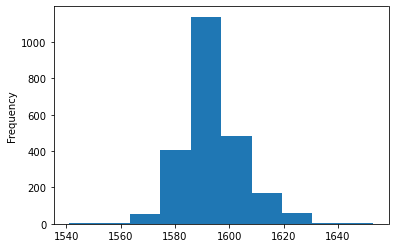

In [120]:
final_df['Температура_y'].plot.hist()
final_df['Температура_y'].describe()

In [121]:
final_df

,key,electricity,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,...,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15,Температура_x,Температура_y
0,1,1442.377754,60.059998,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,206.0,0.0,150.0,154.0,1571.0,1613.0
1,2,881.233565,96.052315,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,206.0,0.0,149.0,154.0,1581.0,1602.0
2,3,525.066777,91.160157,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,205.0,0.0,152.0,153.0,1596.0,1599.0
3,4,796.911309,89.063515,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,207.0,0.0,153.0,154.0,1601.0,1625.0
4,5,1199.137958,89.238236,9.11456,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,203.0,0.0,151.0,152.0,1576.0,1602.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2442,2495,778.818234,89.150879,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,90.0,0.0,256.0,0.0,129.0,223.0,1570.0,1591.0
2443,2496,875.261419,114.179527,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,122.0,0.0,256.0,0.0,129.0,226.0,1554.0,1591.0
2444,2497,556.930349,94.086723,9.04800,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,230.0,0.0,124.0,226.0,1571.0,1589.0
2445,2498,767.817794,118.110717,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,101.0,0.0,206.0,0.0,129.0,207.0,1591.0,1594.0


In [122]:
final_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2330 entries, 0 to 2446
Data columns (total 28 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   key            2330 non-null   int64  
 1   electricity    2330 non-null   float64
 2   Wire 1         2330 non-null   float64
 3   Wire 2         2330 non-null   float64
 4   Wire 3         2330 non-null   float64
 5   Wire 4         2330 non-null   float64
 6   Wire 5         2330 non-null   float64
 7   Wire 6         2330 non-null   float64
 8   Wire 7         2330 non-null   float64
 9   Wire 8         2330 non-null   float64
 10  Wire 9         2330 non-null   float64
 11  Bulk 1         2330 non-null   float64
 12  Bulk 2         2330 non-null   float64
 13  Bulk 3         2330 non-null   float64
 14  Bulk 4         2330 non-null   float64
 15  Bulk 5         2330 non-null   float64
 16  Bulk 6         2330 non-null   float64
 17  Bulk 7         2330 non-null   float64
 18  Bulk 8  

In [123]:
final_df = final_df.merge(alloy_blow_data, on='key', how='left')

In [124]:
final_df.dropna(inplace=True)

In [125]:
final_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2328 entries, 0 to 2329
Data columns (total 29 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   key            2328 non-null   int64  
 1   electricity    2328 non-null   float64
 2   Wire 1         2328 non-null   float64
 3   Wire 2         2328 non-null   float64
 4   Wire 3         2328 non-null   float64
 5   Wire 4         2328 non-null   float64
 6   Wire 5         2328 non-null   float64
 7   Wire 6         2328 non-null   float64
 8   Wire 7         2328 non-null   float64
 9   Wire 8         2328 non-null   float64
 10  Wire 9         2328 non-null   float64
 11  Bulk 1         2328 non-null   float64
 12  Bulk 2         2328 non-null   float64
 13  Bulk 3         2328 non-null   float64
 14  Bulk 4         2328 non-null   float64
 15  Bulk 5         2328 non-null   float64
 16  Bulk 6         2328 non-null   float64
 17  Bulk 7         2328 non-null   float64
 18  Bulk 8  

In [126]:
final_df.corr()

,key,electricity,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,...,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15,Температура_x,Температура_y,Газ 1
key,1.000000,-0.008369,-0.013244,0.043437,-0.027219,0.049297,NaN,-0.008180,0.037029,-0.035970,...,-0.039692,0.063021,0.035033,0.026666,-0.015763,-0.110598,-0.044828,-0.019051,-0.096599,-0.043516
electricity,-0.008369,1.000000,0.005697,0.015631,0.006189,0.031618,NaN,0.036955,0.006136,0.000983,...,-0.001910,-0.001896,0.066087,0.479953,0.160656,0.441353,0.309157,-0.333219,0.274599,0.319284
Wire 1,-0.013244,0.005697,1.000000,-0.068451,0.038047,-0.142035,NaN,-0.128077,-0.067523,0.017216,...,0.022578,0.062654,-0.117816,0.169889,0.039422,-0.053698,0.118117,0.209392,0.317362,0.117331
Wire 2,0.043437,0.015631,-0.068451,1.000000,0.094052,-0.033775,NaN,-0.058729,-0.016209,0.069260,...,0.066721,-0.103820,0.062028,-0.098605,-0.001407,0.036436,-0.096781,-0.086157,-0.207076,0.104261
Wire 3,-0.027219,0.006189,0.038047,0.094052,1.000000,0.169807,NaN,0.183451,0.100391,-0.008193,...,-0.008286,-0.027989,-0.021839,-0.120581,-0.008688,-0.008833,-0.118198,-0.000192,-0.047624,0.103384
Wire 4,0.049297,0.031618,-0.142035,-0.033775,0.169807,1.000000,NaN,0.445959,0.602964,-0.004560,...,-0.004611,-0.015577,-0.012159,-0.085604,-0.004836,-0.121821,-0.091431,0.064984,-0.159821,0.145414
Wire 5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Wire 6,-0.008180,0.036955,-0.128077,-0.058729,0.183451,0.445959,NaN,1.000000,0.302741,-0.007968,...,-0.008058,-0.017812,0.008692,-0.042812,-0.008450,-0.052364,-0.032504,0.019872,-0.084135,0.108091
Wire 7,0.037029,0.006136,-0.067523,-0.016209,0.100391,0.602964,NaN,0.302741,1.000000,-0.002188,...,-0.002213,-0.007476,-0.005835,-0.041081,-0.002321,-0.058461,-0.043877,0.044768,-0.137336,0.078953
Wire 8,-0.035970,0.000983,0.017216,0.069260,-0.008193,-0.004560,NaN,-0.007968,-0.002188,1.000000,...,0.974969,-0.017095,-0.013343,-0.055835,-0.005307,0.043676,-0.090029,-0.023270,-0.010813,0.118069


In [127]:
final_df = final_df.drop('Wire 5', axis=1)

# Linear_regression

In [128]:
x = final_df.drop(['key','Температура_y'], axis=1)

In [129]:
y = final_df['Температура_y']

In [130]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=12345)

In [131]:
cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=22)

In [132]:
lin_reg = LinearRegression()

In [133]:
lin_reg.fit(X_train, y_train)

LinearRegression()

In [134]:
cv_lin_reg = cross_val_score(lin_reg, X_train, y_train, cv=cv, scoring='neg_mean_absolute_error')
cv_lin_reg.mean()*(-1)

6.652213086665339

## DecisionTreeRegression

In [135]:
# Hyper parameters range intialization for tuning 

parameters={"splitter":["best"],
            "max_depth" : [11,15,20,25,30,35,40],
           "min_samples_leaf":[1,2,3,4,5,6,7,8,9,10],
           "max_leaf_nodes":[None,10,20,30,40,50,60,70,80,90] }

In [136]:
reg_decision_model=DecisionTreeRegressor(criterion='absolute_error', random_state=12345)

In [140]:
tuning_model=GridSearchCV(reg_decision_model,param_grid=parameters,scoring='neg_mean_absolute_error',cv=cv,verbose=3)

In [141]:
tuning_model.fit(X_train,y_train)

Fitting 5 folds for each of 700 candidates, totalling 3500 fits
[CV 1/5] END max_depth=11, max_leaf_nodes=None, min_samples_leaf=1, splitter=best;, score=-7.811 total time=   0.2s
[CV 2/5] END max_depth=11, max_leaf_nodes=None, min_samples_leaf=1, splitter=best;, score=-8.247 total time=   0.2s
[CV 3/5] END max_depth=11, max_leaf_nodes=None, min_samples_leaf=1, splitter=best;, score=-7.543 total time=   0.2s
[CV 4/5] END max_depth=11, max_leaf_nodes=None, min_samples_leaf=1, splitter=best;, score=-8.386 total time=   0.2s
[CV 5/5] END max_depth=11, max_leaf_nodes=None, min_samples_leaf=1, splitter=best;, score=-7.669 total time=   0.2s
[CV 1/5] END max_depth=11, max_leaf_nodes=None, min_samples_leaf=2, splitter=best;, score=-8.257 total time=   0.2s
[CV 2/5] END max_depth=11, max_leaf_nodes=None, min_samples_leaf=2, splitter=best;, score=-7.934 total time=   0.2s
[CV 3/5] END max_depth=11, max_leaf_nodes=None, min_samples_leaf=2, splitter=best;, score=-7.524 total time=   0.2s
[CV 4/5]

GridSearchCV(cv=ShuffleSplit(n_splits=5, random_state=22, test_size=0.2, train_size=None),
             estimator=DecisionTreeRegressor(criterion='absolute_error',
                                             random_state=12345),
             param_grid={'max_depth': [11, 15, 20, 25, 30, 35, 40],
                         'max_leaf_nodes': [None, 10, 20, 30, 40, 50, 60, 70,
                                            80, 90],
                         'min_samples_leaf': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
                         'splitter': ['best']},
             scoring='neg_mean_absolute_error', verbose=3)

In [142]:
tuning_model.best_score_

-6.963538873994638

In [143]:
tuning_model.best_params_

{'max_depth': 11,
 'max_leaf_nodes': 20,
 'min_samples_leaf': 10,
 'splitter': 'best'}

## Random Forest

In [144]:
parametrs = { 'n_estimators': [500, 1000],
              'max_depth': range (1, 31, 10),
              'min_samples_split': [2, 4, 8]}

In [145]:
forest = GridSearchCV(RandomForestRegressor(random_state=22), 
                      param_grid=parametrs, scoring='neg_mean_absolute_error', cv=cv)

In [146]:
forest.fit(X_train,y_train)

GridSearchCV(cv=ShuffleSplit(n_splits=5, random_state=22, test_size=0.2, train_size=None),
             estimator=RandomForestRegressor(random_state=22),
             param_grid={'max_depth': range(1, 31, 10),
                         'min_samples_split': [2, 4, 8],
                         'n_estimators': [500, 1000]},
             scoring='neg_mean_absolute_error')

In [147]:
forest.best_params_

{'max_depth': 21, 'min_samples_split': 8, 'n_estimators': 1000}

In [148]:
forest.best_score_*(-1)

6.19456270771815

## LGBM

In [149]:
parameters = {'max_depth': [2, 4, 6],
              'learning_rate': [0.01, 0.03, 0.1],
              'n_estimators': [100, 200, 500, 1000]}

In [150]:
lgbm = LGBMRegressor(random_state=22)

In [151]:
grid_cv = GridSearchCV(lgbm, parameters, scoring='neg_mean_absolute_error', cv=cv)

In [152]:
grid_cv.fit(X_train,y_train)

GridSearchCV(cv=ShuffleSplit(n_splits=5, random_state=22, test_size=0.2, train_size=None),
             estimator=LGBMRegressor(random_state=22),
             param_grid={'learning_rate': [0.01, 0.03, 0.1],
                         'max_depth': [2, 4, 6],
                         'n_estimators': [100, 200, 500, 1000]},
             scoring='neg_mean_absolute_error')

In [153]:
grid_cv.best_score_*(-1)

6.181351020407591

In [154]:
grid_cv.best_params_

{'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 500}

## Catboost

In [155]:
parameters = {'max_depth': [2, 4, 8, 10],
              'learning_rate': [0.01, 0.03, 0.1],
              'l2_leaf_reg': [1, 3, 5],
              'iterations': [50, 100, 200]
             }

In [156]:
catboost = CatBoostRegressor(loss_function='MAE', random_state=22)

In [157]:
grid_search_result = catboost.grid_search(parameters, X=X_train, y=y_train, cv=cv, verbose=0, plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 1577.4732566	test: 1578.0293291	best: 1578.0293291 (0)	total: 62.7ms	remaining: 3.07s
1:	learn: 1561.7029616	test: 1562.2589330	best: 1562.2589330 (1)	total: 64.2ms	remaining: 1.54s
2:	learn: 1546.0984922	test: 1546.6540099	best: 1546.6540099 (2)	total: 65.4ms	remaining: 1.02s
3:	learn: 1530.6407074	test: 1531.2785596	best: 1531.2785596 (3)	total: 66.8ms	remaining: 768ms
4:	learn: 1515.3386318	test: 1515.9762164	best: 1515.9762164 (4)	total: 68.2ms	remaining: 614ms
5:	learn: 1500.1916329	test: 1500.8296370	best: 1500.8296370 (5)	total: 69.4ms	remaining: 509ms
6:	learn: 1485.1997507	test: 1485.8380767	best: 1485.8380767 (6)	total: 70.8ms	remaining: 435ms
7:	learn: 1470.3522815	test: 1470.9905922	best: 1470.9905922 (7)	total: 72ms	remaining: 378ms
8:	learn: 1455.6536089	test: 1456.2916329	best: 1456.2916329 (8)	total: 73.4ms	remaining: 334ms
9:	learn: 1441.1156875	test: 1441.7497201	best: 1441.7497201 (9)	total: 74.4ms	remaining: 298ms
10:	learn: 1426.7076959	test: 1427.3413163

In [158]:
catboost.get_params()

{'loss_function': 'MAE',
 'random_state': 22,
 'depth': 2,
 'l2_leaf_reg': 3,
 'iterations': 200,
 'learning_rate': 0.1}

In [159]:
catboost.get_best_score()

{'learn': {'MAE': 5.542954426237677}}

In [160]:
d = {'model' : ["linear regression", 'Decision Tree Regressor', 'Random Forest', 'LGBM', 'Catboost'],
     'CV_MAE' : [6.652, 6.963, 6.194, 6.181, 5.543]}
df_total = pd.DataFrame(data=d)

In [161]:
df_total

,model,CV_MAE
0,linear regression,6.652
1,Decision Tree Regressor,6.963
2,Random Forest,6.194
3,LGBM,6.181
4,Catboost,5.543


По результатам нашей работы мы выяснили, что заказчику следует предложить модель `CatBoostRegressor` для прогнозирования температуры стали, что может привести к уменьшению затрат на электроэнергию.

**Комментарий студента**

Хорошо все замечания посторался исправить, а теперь поскольку самая лучшая метрика у нас получилась на модели Catboost, посмотрим какие именно значения MAE у нас получатся на тестовой выборке

In [162]:
mean_absolute_error(y_test,catboost.predict(X_test))

6.227645894573097

Модель `CatBoostRegressor` показала точность в 6.23 градусов по метрике МАЕ на тестовой выборке. Таким образом, предсказанная температура отличается от реальной менее чем на 7 градусов.

# Финальный отчет

**Вопрос**: Какие пункты плана были выполнены, а какие — нет (поясните почему)?<br>
**Ответ**: В целом смотря на свой план, я осуществил все пункты своего плана, изначально хотел сделать немного больше новых фичей(напр.суммарное кол-во добавленного проволочного/сыпчатого материала), но позже передумал, поскольку как мне показалось что скорее всего у каждого резервуара с материалов будет своя тугоплавкость что будет влиять на исход модели.<br>
**Вопрос**:Какие ключевые шаги в решении задачи выделили?<br>
**Ответ**: Ключевым этапом как мне кажется решения любой задачи является этап с анализом и обработкой данных поскольку от него будет зависеть на сколько модель будет правильно функционироватьпо дефолту(А конкретно это то что были найдены ключи с отсутсвующими последними температурами и ключи где отсутвовало добавление каких либо материалов). И лишь после этого этапа будут осуществляться все последующие этапы такие как создание новых фичей и подбор модели и ее гиперпараметров. 